In [2]:
import importlib.util
def module_from_file(module_name, file_path): #The code that imports the file which originated the training with all the instructions
            spec = importlib.util.spec_from_file_location(module_name, file_path)
            module = importlib.util.module_from_spec(spec)
            spec.loader.exec_module(module)
            return module

from importlib import import_module
#foo = import_module(fold_folder+'/Funs.py', package=None)


folder = './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20lrs4'
foo = module_from_file("foo", f'{folder}/Funs.py')

import random as rd  
from scipy.stats import norm
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.metrics import log_loss

tff = foo.tff # tensorflow routines 
ut = foo.ut # utilities
ln = foo.ln #Learn2_new.py
print("==Checking GPU==")
import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

print("==Checking CUDA==")
tf.test.is_built_with_cuda()

#from tensorflow.keras.preprocessing.image import ImageDataGenerator
sys.path.insert(1, '../ERA')

print("==Reading data==")

year_permutation = np.load(f'{folder}/year_permutation.npy')

run_vae_kwargs = ut.json2dict(f"{folder}/config.json")
T = ut.extract_nested(run_vae_kwargs, 'T')
if (ut.keys_exists(run_vae_kwargs, 'label_period_start') and ut.keys_exists(run_vae_kwargs, 'label_period_end')):
    label_period_start = ut.extract_nested(run_vae_kwargs, 'label_period_start')
    label_period_end = ut.extract_nested(run_vae_kwargs, 'label_period_end')
    time_start = ut.extract_nested(run_vae_kwargs, 'time_start')
    time_end = ut.extract_nested(run_vae_kwargs, 'time_end')
    
    
n_days = time_end-time_start-T+1
n_days

import numpy as np
import pickle


2022-09-22 12:22:20.464458: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
In this environment you cannot import Basemap
In this environment you cannot import Basemap


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
==Checking GPU==
==Checking CUDA==
==Reading data==


2022-09-22 12:22:23.442880: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-22 12:22:23.445672: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-22 12:22:23.445689: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-22 12:22:23.445706: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (r740server5): /proc/driver/nvidia/version does not exist
2022-09-22 12:22:23.445715: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creat

In [9]:
logits = tf.constant([1., -1., 0., 1., -1., 0., 0.])
labels = tf.constant([0., 0., 0., 1., 1., 1., 0.5])
tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits).numpy()

2022-08-25 13:39:54.632481: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-25 13:39:54.633847: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


array([1.3132617, 0.3132617, 0.6931472, 0.3132617, 1.3132617, 0.6931472,
       0.6931472], dtype=float32)

In [10]:
-labels*np.log(tf.sigmoid(logits)) + (1 - labels) * -np.log(1 - tf.sigmoid(logits))

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([1.3132617 , 0.31326166, 0.6931472 , 0.31326166, 1.3132616 ,
       0.6931472 , 0.6931472 ], dtype=float32)>

NA/3scalars/
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.40+-0.05, 50.0, 10
0.29+-0.05, 50.0, 10
0.22+-0.05, 50.0, 10
0.19+-0.06, 10.0, 20
0.18+-0.06, 10.0, 20
0.18+-0.05, 10.0, 10


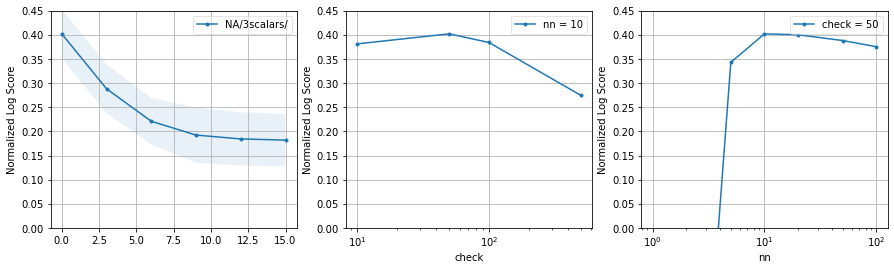

In [11]:
runs = {'NA/3scalars/' : './xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        }

import matplotlib.pyplot as plt
fig2 = plt.figure()
fig2.set_size_inches(15, 4)
ax = fig2.subplots(nrows=1, ncols=3)
setnn = 10
setcheck = 50
for name, folder in runs.items():
        print(name)
        open_file = open(f'{folder}/committor.pkl', "rb")
        committor_dictionary = pickle.load(open_file)
        open_file.close()
        committor = committor_dictionary['committor']
        print(committor_dictionary.keys())
        print(committor_dictionary['RunFolds_kwargs_default'])
        delay = ut.extract_nested(committor_dictionary['RunFolds_kwargs_default'],'delay')
        chain_step = ut.extract_nested(committor_dictionary['RunFolds_kwargs_default'],'chain_step')
        import pandas as pd
        skill = committor_dictionary['skill']
        skill = []
        for check, value_check in committor_dictionary['skill'].items():
                score_nn = []
                for nn, value_nn in value_check.items():     
                        score_fold = []
                        for fold, value_fold in value_nn.items():
                                score_fold.append(pd.DataFrame([value_fold], columns = -delay*chain_step) )
                        score_nn.append(pd.concat(score_fold, keys=value_nn.keys(),names=['fold', None]))
                skill.append(pd.concat(score_nn, keys=value_check.keys(),names=['nn','fold', None]))
        skill = pd.concat(skill, keys =committor_dictionary['skill'].keys(), names=['check','nn','fold', None] )
        meanskill = skill.groupby(['check', 'nn']).mean() #.loc[(slice(None), 1), 'skill'] #.droplevel(level=(1,2)) 
        stdskill = skill.groupby(['check', 'nn']).std()
        tauarray = np.array([-tau for tau in meanskill])
        meanskilarray = np.array([meanskill[tau].max() for tau in meanskill])
        stdskillarray = np.array([stdskill[tau][meanskill[tau].idxmax()] for tau in stdskill])
        ax[0].plot(tauarray, meanskilarray,label=name, marker='.')
        ax[0].fill_between(tauarray,meanskilarray-stdskillarray,meanskilarray+stdskillarray,alpha=0.1)
        meanskill[0][(slice(None),setnn)].plot(ax = ax[1], label=f'nn = {setnn}', marker='.')
        meanskill[0].loc[pd.IndexSlice[setcheck,:]].droplevel(level=(0)).plot(ax = ax[2], label=f'check = {setcheck}', marker='.')
        for j in list(meanskill.columns):
                print(f"{meanskill[j].max():.2f}+-{stdskill[j][meanskill[j].idxmax()]:.2f}, {meanskill[j].idxmax()[0]}, {meanskill[j].idxmax()[1]}")
ax[1].set_xscale('log')
ax[2].set_xscale('log')
#ax1.set_ylabel('skill')
#ax.set_ylim([0,0.5])
#ax.set_yscale("log")
for i in range(3):
        ax[i].legend(loc='best', fancybox=True, framealpha=0.5)
        ax[i].grid(True)
        ax[i].set_ylabel('Normalized Log Score')
        ax[i].set_ylim([0,0.45])

fig2.savefig('./Images/analog_taus.png',dpi=200,bbox_inches='tight')

Raw Analogs
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.40+-0.05, 50.0, 10
0.29+-0.05, 50.0, 10
0.22+-0.05, 50.0, 10
0.19+-0.06, 10.0, 20
0.18+-0.06, 10.0, 20
0.18+-0.05, 10.0, 10
North Atlantic ResNet (16)
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.36+-0.04, 10, 10
0.23+-0.04, 10, 10
0.15+-0.03, 10, 10
0.11+-0.04, 10, 5
0.10+-0.03, 10, 5
0.09+-0.03, 10, 5
North Hemisphere (64)
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 

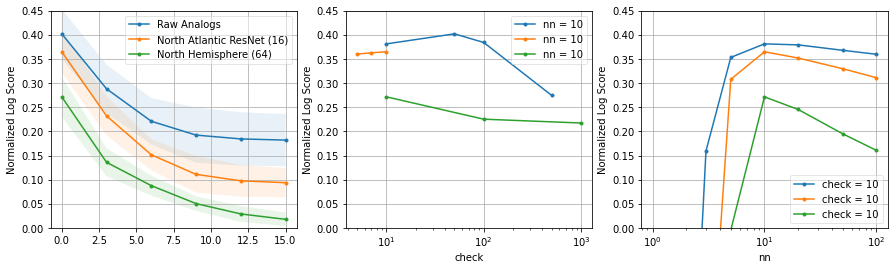

In [12]:
runs = {'Raw Analogs' : './xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        #,'NA/Z8//fw20.1.20lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20lrs4/'
        #,'NA/Z8//fw20.4.20lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.4.20lrs4/'
        #,'NA/Z8//fw20.1.20kl.5.5lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20kl.5.5lrs4/'
        #,'NA/Z8/yrs500/fw20.1.20skip2' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20skip2/'
        #,'NA/Z16//fw20.1.20lrs4' : './xforanalogs/NA24by48/Z16/yrs500/interT15fw20.1.20lrs4/'
        ,'North Atlantic ResNet (16)' : './xforanalogs/NA24by48/Z16/yrs500/interT15fw20.1.20kl.99.01skip2/'
        ,'North Hemisphere (64)' : './xforanalogs/NH24by128/Z64/yrs500/interT15fw20.1.20lrs4/'
        }

import matplotlib.pyplot as plt
fig2 = plt.figure()
fig2.set_size_inches(15, 4)
ax = fig2.subplots(nrows=1, ncols=3)
setnn = 10
setcheck = 10
for name, folder in runs.items():
        print(name)
        open_file = open(f'{folder}/committor.pkl', "rb")
        committor_dictionary = pickle.load(open_file)
        open_file.close()
        committor = committor_dictionary['committor']
        print(committor_dictionary.keys())
        print(committor_dictionary['RunFolds_kwargs_default'])
        delay = ut.extract_nested(committor_dictionary['RunFolds_kwargs_default'],'delay')
        chain_step = ut.extract_nested(committor_dictionary['RunFolds_kwargs_default'],'chain_step')
        import pandas as pd
        skill = committor_dictionary['skill']
        skill = []
        for check, value_check in committor_dictionary['skill'].items():
                score_nn = []
                for nn, value_nn in value_check.items():     
                        score_fold = []
                        for fold, value_fold in value_nn.items():
                                score_fold.append(pd.DataFrame([value_fold], columns = -delay*chain_step) )
                        score_nn.append(pd.concat(score_fold, keys=value_nn.keys(),names=['fold', None]))
                skill.append(pd.concat(score_nn, keys=value_check.keys(),names=['nn','fold', None]))
        skill = pd.concat(skill, keys =committor_dictionary['skill'].keys(), names=['check','nn','fold', None] )
        meanskill = skill.groupby(['check', 'nn']).mean() #.loc[(slice(None), 1), 'skill'] #.droplevel(level=(1,2)) 
        stdskill = skill.groupby(['check', 'nn']).std()
        tauarray = np.array([-tau for tau in meanskill])
        meanskilarray = np.array([meanskill[tau].max() for tau in meanskill])
        stdskillarray = np.array([stdskill[tau][meanskill[tau].idxmax()] for tau in stdskill])
        ax[0].plot(tauarray, meanskilarray,label=name, marker='.')
        ax[0].fill_between(tauarray,meanskilarray-stdskillarray,meanskilarray+stdskillarray,alpha=0.1)
        meanskill[0][(slice(None),setnn)].plot(ax = ax[1], label=f'nn = {setnn}', marker='.')
        meanskill[0].loc[pd.IndexSlice[setcheck,:]].droplevel(level=(0)).plot(ax = ax[2], label=f'check = {setcheck}', marker='.')
        for j in list(meanskill.columns):
                print(f"{meanskill[j].max():.2f}+-{stdskill[j][meanskill[j].idxmax()]:.2f}, {meanskill[j].idxmax()[0]}, {meanskill[j].idxmax()[1]}")
ax[1].set_xscale('log')
ax[2].set_xscale('log')
#ax1.set_ylabel('skill')
#ax.set_ylim([0,0.5])
#ax.set_yscale("log")
for i in range(3):
        ax[i].legend(loc='best', fancybox=True, framealpha=0.5)
        ax[i].grid(True)
        ax[i].set_ylabel('Normalized Log Score')
        ax[i].set_ylim([0,0.45])

fig2.savefig('./Images/analog_taus.png',dpi=200,bbox_inches='tight')

North Atlantic (64)
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.39+-0.04, 10.0, 20
0.28+-0.05, 10.0, 10
0.22+-0.05, 10.0, 10
0.19+-0.05, 10.0, 10
0.18+-0.05, 10.0, 10
0.18+-0.05, 5.0, 10


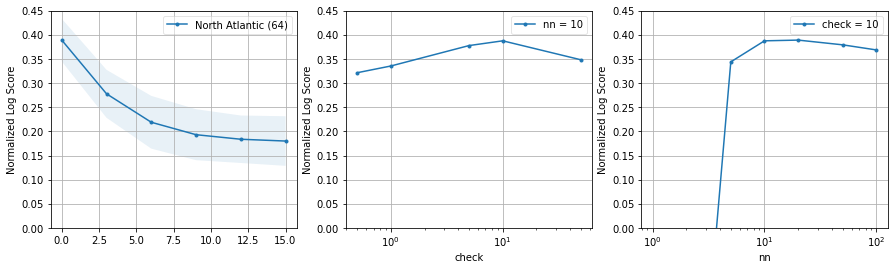

In [3]:
runs = {#'Raw Analog' : './xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        #,'NA/Z8//fw20.1.20lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20lrs4/'
        #,'NA/Z8//fw20.4.20lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.4.20lrs4/'
        #,'NA/Z8//fw20.1.20kl.5.5lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20kl.5.5lrs4/'
        #,'NA/Z8/yrs500/fw20.1.20skip2' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20skip2/'
        #,'NA/Z16//fw20.1.20lrs4' : './xforanalogs/NA24by48/Z16/yrs500/interT15fw20.1.20lrs4/'
        #,'NA/Z16//fw20.1.20kl.99.01skip2' : './xforanalogs/NA24by48/Z16/yrs500/interT15fw20.1.20kl.99.01skip2/'
        #,'NH/Z64/fw20.1.20lrs4' : './xforanalogs/NH24by128/Z64/yrs500/interT15fw20.1.20lrs4/'
        #,'ZG' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGlrs4/'
        #,'ZGfw1.1.1' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15fw1.1.1ZGlrs4/'
        #,'ZGskip2' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGskip2/'
        #,'ZGskip2with10epochs' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGskip2with10epochs/'
        #,'ZGkl.99.01skip2' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGkl.99.01skip2/'
        #,'North Atlantic ResNet (16)' : './xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20ZGskip2/'
        #,'Z64/fw1.1.1' : './xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw1.1.1ZGlrs4/'
        'North Atlantic (64)' : './xforanalogs/ZGonlyNA24by48/Z64/yrs500/interT15fw20.1.20ZGlrs4'
        #,'Z64/fw1.1.1epoch10' : './xforanalogs/ZGonlyNA24by48/Z64/yrs500/interT15fw1.1.1ZGepoch10lrs4/'
        #,'Z64/fw20.1.20epoch10skip2' :'./xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20ZG10epochsskip2/'
        }

import matplotlib.pyplot as plt
fig2 = plt.figure()
fig2.set_size_inches(15, 4)
ax = fig2.subplots(nrows=1, ncols=3)
setnn = 10
setcheck = 10
for name, folder in runs.items():
        print(name)
        open_file = open(f'{folder}/committor.pkl', "rb")
        committor_dictionary = pickle.load(open_file)
        open_file.close()
        committor = committor_dictionary['committor']
        print(committor_dictionary.keys())
        print(committor_dictionary['RunFolds_kwargs_default'])
        delay = ut.extract_nested(committor_dictionary['RunFolds_kwargs_default'],'delay')
        chain_step = ut.extract_nested(committor_dictionary['RunFolds_kwargs_default'],'chain_step')
        import pandas as pd
        skill = committor_dictionary['skill']
        skill = []
        for check, value_check in committor_dictionary['skill'].items():
                score_nn = []
                for nn, value_nn in value_check.items():     
                        score_fold = []
                        for fold, value_fold in value_nn.items():
                                score_fold.append(pd.DataFrame([value_fold], columns = -delay*chain_step) )
                        score_nn.append(pd.concat(score_fold, keys=value_nn.keys(),names=['fold', None]))
                skill.append(pd.concat(score_nn, keys=value_check.keys(),names=['nn','fold', None]))
        skill = pd.concat(skill, keys =committor_dictionary['skill'].keys(), names=['check','nn','fold', None] )
        meanskill = skill.groupby(['check', 'nn']).mean() #.loc[(slice(None), 1), 'skill'] #.droplevel(level=(1,2)) 
        stdskill = skill.groupby(['check', 'nn']).std()
        tauarray = np.array([-tau for tau in meanskill])
        meanskilarray = np.array([meanskill[tau].max() for tau in meanskill])
        stdskillarray = np.array([stdskill[tau][meanskill[tau].idxmax()] for tau in stdskill])
        ax[0].plot(tauarray, meanskilarray,label=name, marker='.')
        ax[0].fill_between(tauarray,meanskilarray-stdskillarray,meanskilarray+stdskillarray,alpha=0.1)
        meanskill[0][(slice(None),setnn)].plot(ax = ax[1], label=f'nn = {setnn}', marker='.')
        meanskill[0].loc[pd.IndexSlice[setcheck,:]].droplevel(level=(0)).plot(ax = ax[2], label=f'check = {setcheck}', marker='.')
        for j in list(meanskill.columns):
                print(f"{meanskill[j].max():.2f}+-{stdskill[j][meanskill[j].idxmax()]:.2f}, {meanskill[j].idxmax()[0]}, {meanskill[j].idxmax()[1]}")
ax[1].set_xscale('log')
ax[2].set_xscale('log')
#ax1.set_ylabel('skill')
#ax.set_ylim([0,0.5])
#ax.set_yscale("log")
for i in range(3):
        ax[i].legend(loc='best', fancybox=True, framealpha=0.5)
        ax[i].grid(True)
        ax[i].set_ylabel('Normalized Log Score')
        ax[i].set_ylim([0,0.45])

fig2.savefig('./Images/analog_taus.png',dpi=200,bbox_inches='tight')

Raw Analog
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.40+-0.05, 50.0, 10
0.29+-0.05, 50.0, 10
0.22+-0.05, 50.0, 10
0.19+-0.06, 10.0, 20
0.18+-0.06, 10.0, 20
0.18+-0.05, 10.0, 10
Z16/yrs2000/skip2lr5e-5
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.39+-0.02, 10.0, 10
0.27+-0.02, 5.0, 10
0.22+-0.02, 5.0, 10
0.19+-0.02, 5.0, 10
0.17+-0.02, 5.0, 10
0.16+-0.02, 5.0, 10
Raw Analog/yrs2000
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield

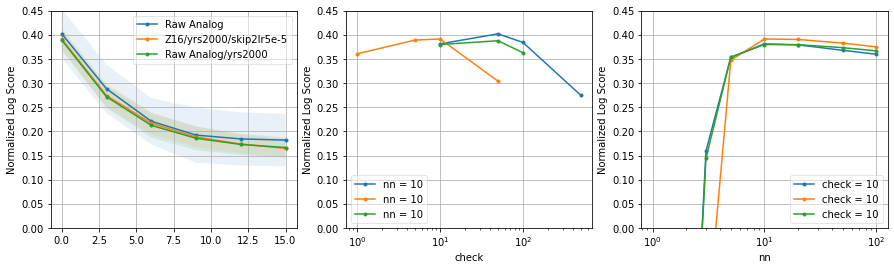

In [14]:
runs = {'Raw Analog' : './xforanalogs/NA24by48/global_logit/yrs500/interT15/'
         ,'Z16/yrs2000/skip2lr5e-5' : 'xforanalogs/ZGonlyNA24by48/Z16/yrs2000/interT15fw20.1.20ZGskip2lr5e-5/'
         ,'Raw Analog/yrs2000' :'./xforanalogs/NA24by48/global_logit/yrs2000/interT15/'
        }

import matplotlib.pyplot as plt
fig2 = plt.figure()
fig2.set_size_inches(15, 4)
ax = fig2.subplots(nrows=1, ncols=3)
setnn = 10
setcheck = 10
for name, folder in runs.items():
        print(name)
        open_file = open(f'{folder}/committor.pkl', "rb")
        committor_dictionary = pickle.load(open_file)
        open_file.close()
        committor = committor_dictionary['committor']
        print(committor_dictionary.keys())
        print(committor_dictionary['RunFolds_kwargs_default'])
        delay = ut.extract_nested(committor_dictionary['RunFolds_kwargs_default'],'delay')
        chain_step = ut.extract_nested(committor_dictionary['RunFolds_kwargs_default'],'chain_step')
        import pandas as pd
        skill = committor_dictionary['skill']
        skill = []
        for check, value_check in committor_dictionary['skill'].items():
                score_nn = []
                for nn, value_nn in value_check.items():     
                        score_fold = []
                        for fold, value_fold in value_nn.items():
                                score_fold.append(pd.DataFrame([value_fold], columns = -delay*chain_step) )
                        score_nn.append(pd.concat(score_fold, keys=value_nn.keys(),names=['fold', None]))
                skill.append(pd.concat(score_nn, keys=value_check.keys(),names=['nn','fold', None]))
        skill = pd.concat(skill, keys =committor_dictionary['skill'].keys(), names=['check','nn','fold', None] )
        meanskill = skill.groupby(['check', 'nn']).mean() #.loc[(slice(None), 1), 'skill'] #.droplevel(level=(1,2)) 
        stdskill = skill.groupby(['check', 'nn']).std()
        tauarray = np.array([-tau for tau in meanskill])
        meanskilarray = np.array([meanskill[tau].max() for tau in meanskill])
        stdskillarray = np.array([stdskill[tau][meanskill[tau].idxmax()] for tau in stdskill])
        ax[0].plot(tauarray, meanskilarray,label=name, marker='.')
        ax[0].fill_between(tauarray,meanskilarray-stdskillarray,meanskilarray+stdskillarray,alpha=0.1)
        meanskill[0][(slice(None),setnn)].plot(ax = ax[1], label=f'nn = {setnn}', marker='.')
        meanskill[0].loc[pd.IndexSlice[setcheck,:]].droplevel(level=(0)).plot(ax = ax[2], label=f'check = {setcheck}', marker='.')
        for j in list(meanskill.columns):
                print(f"{meanskill[j].max():.2f}+-{stdskill[j][meanskill[j].idxmax()]:.2f}, {meanskill[j].idxmax()[0]}, {meanskill[j].idxmax()[1]}")
ax[1].set_xscale('log')
ax[2].set_xscale('log')
#ax1.set_ylabel('skill')
#ax.set_ylim([0,0.5])
#ax.set_yscale("log")
for i in range(3):
        ax[i].legend(loc='best', fancybox=True, framealpha=0.5)
        ax[i].grid(True)
        ax[i].set_ylabel('Normalized Log Score')
        ax[i].set_ylim([0,0.45])

fig2.savefig('./Images/analog_taus.png',dpi=200,bbox_inches='tight')

Raw Analog
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.40+-0.05, 50.0, 10
0.29+-0.05, 50.0, 10
0.22+-0.05, 50.0, 10
0.19+-0.06, 10.0, 20
0.18+-0.06, 10.0, 20
0.18+-0.05, 10.0, 10
NAE ResNet (16)
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.39+-0.05, 5.0, 10
0.28+-0.04, 5.0, 10
0.22+-0.05, 5.0, 10
0.19+-0.05, 5.0, 10
0.18+-0.06, 1.0, 5
0.18+-0.06, 1.0, 5
NAE (64)
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'v

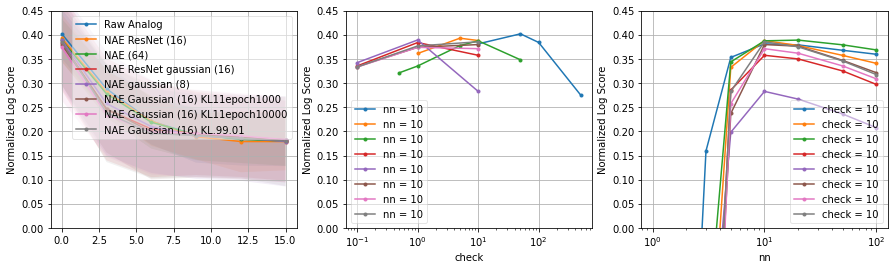

In [5]:
runs = {'Raw Analog' : './xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        #,'NA/Z8//fw20.1.20lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20lrs4/'
        #,'NA/Z8//fw20.4.20lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.4.20lrs4/'
        #,'NA/Z8//fw20.1.20kl.5.5lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20kl.5.5lrs4/'
        #,'NA/Z8/yrs500/fw20.1.20skip2' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20skip2/'
        #,'NA/Z16//fw20.1.20lrs4' : './xforanalogs/NA24by48/Z16/yrs500/interT15fw20.1.20lrs4/'
        #,'NA/Z16//fw20.1.20kl.99.01skip2' : './xforanalogs/NA24by48/Z16/yrs500/interT15fw20.1.20kl.99.01skip2/'
        #,'NH/Z64/fw20.1.20lrs4' : './xforanalogs/NH24by128/Z64/yrs500/interT15fw20.1.20lrs4/'
        #,'ZG' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGlrs4/'
        #,'ZGfw1.1.1' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15fw1.1.1ZGlrs4/'
        #,'ZGskip2' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGskip2/'
        #,'ZGskip2with10epochs' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGskip2with10epochs/'
        #,'ZGkl.99.01skip2' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGkl.99.01skip2/'
        ,'NAE ResNet (16)' : './xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20ZGskip2/'
        #,'Z64/fw1.1.1' : './xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw1.1.1ZGlrs4/'
        ,'NAE (64)' : './xforanalogs/ZGonlyNA24by48/Z64/yrs500/interT15fw20.1.20ZGlrs4/'
        #,'Z64/fw1.1.1epoch10' : './xforanalogs/ZGonlyNA24by48/Z64/yrs500/interT15fw1.1.1ZGepoch10lrs4/'
        #,'Z64/fw20.1.20epoch10skip2' :'./xforanalogs/ZGonlyNA24by48/Z64/yrs500/interT15fw20.1.20ZG10epochsskip2/'
        , 'NAE ResNet gaussian (16)' : './xforanalogsL2loss/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20skip2epochs100/'
        , 'NAE gaussian (8)' : './xforanalogsL2loss/ZGonlyNA24by48/Z8/yrs500/interT15fw20.1.20skip2/'
        , 'NAE Gaussian (16) KL11epoch1000' : './xforanalogsL2loss/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20kl1.1.skip2epochs1000/'
        , 'NAE Gaussian (16) KL11epoch10000' : 'xforanalogsL2loss/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20kl1.1.skip2/'
        , 'NAE Gaussian (16) KL.99.01'   :'xforanalogsL2loss/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20kl.99.01lr1e-3skip2/'
        }

import matplotlib.pyplot as plt
fig2 = plt.figure()
fig2.set_size_inches(15, 4)
ax = fig2.subplots(nrows=1, ncols=3)
setnn = 10
setcheck = 10
for name, folder in runs.items():
        print(name)
        open_file = open(f'{folder}/committor.pkl', "rb")
        committor_dictionary = pickle.load(open_file)
        open_file.close()
        committor = committor_dictionary['committor']
        print(committor_dictionary.keys())
        print(committor_dictionary['RunFolds_kwargs_default'])
        delay = ut.extract_nested(committor_dictionary['RunFolds_kwargs_default'],'delay')
        chain_step = ut.extract_nested(committor_dictionary['RunFolds_kwargs_default'],'chain_step')
        import pandas as pd
        skill = committor_dictionary['skill']
        skill = []
        for check, value_check in committor_dictionary['skill'].items():
                score_nn = []
                for nn, value_nn in value_check.items():     
                        score_fold = []
                        for fold, value_fold in value_nn.items():
                                score_fold.append(pd.DataFrame([value_fold], columns = -delay*chain_step) )
                        score_nn.append(pd.concat(score_fold, keys=value_nn.keys(),names=['fold', None]))
                skill.append(pd.concat(score_nn, keys=value_check.keys(),names=['nn','fold', None]))
        skill = pd.concat(skill, keys =committor_dictionary['skill'].keys(), names=['check','nn','fold', None] )
        meanskill = skill.groupby(['check', 'nn']).mean() #.loc[(slice(None), 1), 'skill'] #.droplevel(level=(1,2)) 
        stdskill = skill.groupby(['check', 'nn']).std()
        tauarray = np.array([-tau for tau in meanskill])
        meanskilarray = np.array([meanskill[tau].max() for tau in meanskill])
        stdskillarray = np.array([stdskill[tau][meanskill[tau].idxmax()] for tau in stdskill])
        ax[0].plot(tauarray, meanskilarray,label=name, marker='.')
        ax[0].fill_between(tauarray,meanskilarray-stdskillarray,meanskilarray+stdskillarray,alpha=0.1)
        meanskill[0][(slice(None),setnn)].plot(ax = ax[1], label=f'nn = {setnn}', marker='.')
        meanskill[0].loc[pd.IndexSlice[setcheck,:]].droplevel(level=(0)).plot(ax = ax[2], label=f'check = {setcheck}', marker='.')
        for j in list(meanskill.columns):
                print(f"{meanskill[j].max():.2f}+-{stdskill[j][meanskill[j].idxmax()]:.2f}, {meanskill[j].idxmax()[0]}, {meanskill[j].idxmax()[1]}")
ax[1].set_xscale('log')
ax[2].set_xscale('log')
#ax1.set_ylabel('skill')
#ax.set_ylim([0,0.5])
#ax.set_yscale("log")
for i in range(3):
        ax[i].legend(loc='best', fancybox=True, framealpha=0.5)
        ax[i].grid(True)
        ax[i].set_ylabel('Normalized Log Score')
        ax[i].set_ylim([0,0.45])

fig2.savefig('./Images/analog_taus.png',dpi=200,bbox_inches='tight')

Raw Analog France 5%
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.40+-0.05, 50.0, 10
0.29+-0.05, 50.0, 10
0.22+-0.05, 50.0, 10
0.19+-0.06, 10.0, 20
0.18+-0.06, 10.0, 20
0.18+-0.05, 10.0, 10
Raw Analog France daily 1%
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 1, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([ 0,  3,  6,  9, 12, 15])}}}
0.32+-0.05, 50.0, 5
0.23+-0.05, 50.0, 5
0.19+-0.05, 50.0, 5
0.16+-0.04, 50.0, 5
0.15+-0.04, 50.0, 5
0.15+-0.04, 10.0, 3
Raw Analog France daily 5%
dict_keys(['committor', 'skill', 'RunFolds_

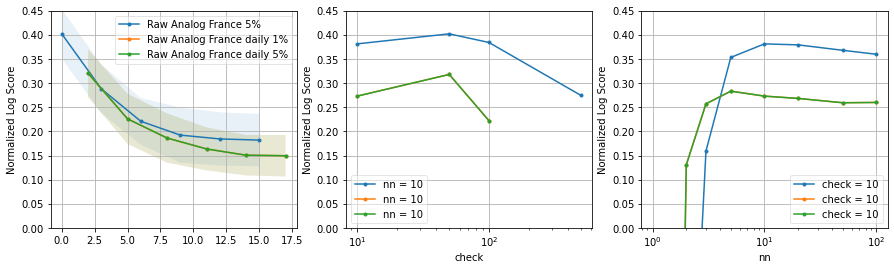

In [2]:
runs = {'Raw Analog France 5%' : './xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        #,'NAE ResNet (16) France' : './xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20ZGskip2/'
          #'Raw Analog Scandinavia 5%' : './xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs500/interT15/'
         #, 'NAE ResNet (16) Scandinavia 5%' : './xforanalogs/ZGonlyNA24by48/Scandinavia/Z16/yrs500/interT15fw20.1.20skip2/'
         #, 'Raw Analog Scandinavia 1%' : './xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs500/Per1interT15/'
         #, 'North Atlantic ResNet (16) 1%' : './xforanalogs/ZGonlyNA24by48/Scandinavia/Z16/yrs500/Per1interT15fw20.1.20skip2/'
         , 'Raw Analog France daily 1%' : './xforanalogs/NA24by48/global_logit/yrs500/interT15daily1percent/'
         , 'Raw Analog France daily 5%' : './xforanalogs/NA24by48/global_logit/yrs500/interT15daily1percent/'
        }

import matplotlib.pyplot as plt
fig2 = plt.figure()
fig2.set_size_inches(15, 4)
ax = fig2.subplots(nrows=1, ncols=3)
setnn = 10
setcheck = 10
for name, folder in runs.items():
        print(name)
        open_file = open(f'{folder}/committor.pkl', "rb")
        committor_dictionary = pickle.load(open_file)
        open_file.close()
        committor = committor_dictionary['committor']
        print(committor_dictionary.keys())
        print(committor_dictionary['RunFolds_kwargs_default'])
        delay = ut.extract_nested(committor_dictionary['RunFolds_kwargs_default'],'delay')
        chain_step = ut.extract_nested(committor_dictionary['RunFolds_kwargs_default'],'chain_step')
        import pandas as pd
        skill = committor_dictionary['skill']
        skill = []
        for check, value_check in committor_dictionary['skill'].items():
                score_nn = []
                for nn, value_nn in value_check.items():     
                        score_fold = []
                        for fold, value_fold in value_nn.items():
                                score_fold.append(pd.DataFrame([value_fold], columns = -delay*chain_step) )
                        score_nn.append(pd.concat(score_fold, keys=value_nn.keys(),names=['fold', None]))
                skill.append(pd.concat(score_nn, keys=value_check.keys(),names=['nn','fold', None]))
        skill = pd.concat(skill, keys =committor_dictionary['skill'].keys(), names=['check','nn','fold', None] )
        meanskill = skill.groupby(['check', 'nn']).mean() #.loc[(slice(None), 1), 'skill'] #.droplevel(level=(1,2)) 
        stdskill = skill.groupby(['check', 'nn']).std()
        tauarray = np.array([-tau for tau in meanskill])
        meanskilarray = np.array([meanskill[tau].max() for tau in meanskill])
        stdskillarray = np.array([stdskill[tau][meanskill[tau].idxmax()] for tau in stdskill])
        
        if (name == 'Raw Analog France daily 1%') or (name == 'Raw Analog France daily 5%'):
                ax[0].plot(tauarray+2, meanskilarray,label=name, marker='.')
                ax[0].fill_between(tauarray+2,meanskilarray-stdskillarray,meanskilarray+stdskillarray,alpha=0.1)
        else:
                ax[0].plot(tauarray, meanskilarray,label=name, marker='.')
                ax[0].fill_between(tauarray,meanskilarray-stdskillarray,meanskilarray+stdskillarray,alpha=0.1)
        meanskill[0][(slice(None),setnn)].plot(ax = ax[1], label=f'nn = {setnn}', marker='.')
        meanskill[0].loc[pd.IndexSlice[setcheck,:]].droplevel(level=(0)).plot(ax = ax[2], label=f'check = {setcheck}', marker='.')
        for j in list(meanskill.columns):
                print(f"{meanskill[j].max():.2f}+-{stdskill[j][meanskill[j].idxmax()]:.2f}, {meanskill[j].idxmax()[0]}, {meanskill[j].idxmax()[1]}")
ax[1].set_xscale('log')
ax[2].set_xscale('log')
#ax1.set_ylabel('skill')
#ax.set_ylim([0,0.5])
#ax.set_yscale("log")
for i in range(3):
        ax[i].legend(loc='best', fancybox=True, framealpha=0.5)
        ax[i].grid(True)
        ax[i].set_ylabel('Normalized Log Score')
        ax[i].set_ylim([0,0.45])

fig2.savefig('./Images/analog_taus.png',dpi=200,bbox_inches='tight')